In [2]:
from __future__ import division
import sys
import argparse
import numpy as np, matplotlib.pyplot as plt
import pretty_midi
import librosa, librosa.display
import itertools
from IPython.display import Audio,display

%matplotlib inline
#plt.rcParams['figure.figsize'] = (14,4)

In [3]:
#parse midi to pretty midi object
midi_fn = '../data/mid/Avril14th.mid'
sr = 22050
pm = pretty_midi.PrettyMIDI(midi_fn)

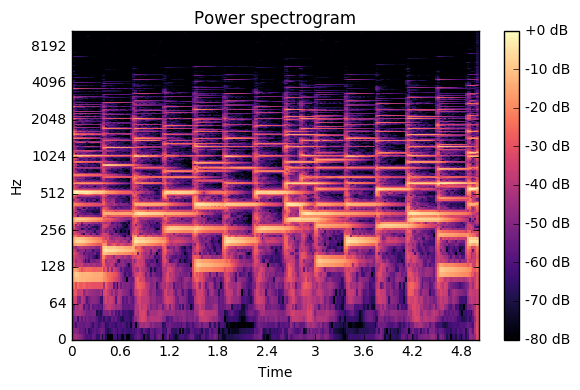

In [4]:
#synthesize to audio, listen, and compute, view spectrogram
y = pm.fluidsynth(fs=sr)[:sr*5]
display(Audio(y,rate=sr))
D = librosa.stft(y)
librosa.display.specshow(librosa.amplitude_to_db(D,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

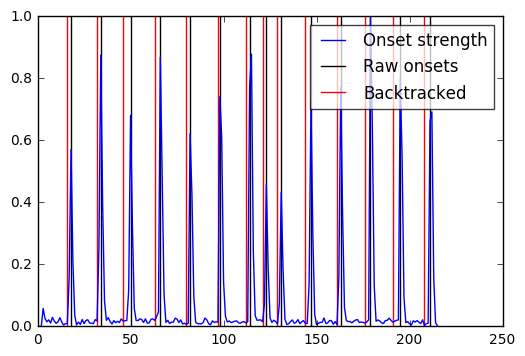

In [5]:
#onsets
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv,
                                        backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
plt.figure()
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.show()

In [32]:
from collections import defaultdict
#chart onsets vs pm note on events
noteons = []
onset_groups = defaultdict(set)

for instrument in pm.instruments:
    for note in instrument.notes:
        if note.start > 0 and note.start <= 5.0:
            noteons.append(note.start)
            onset_groups[note.start].add(note.pitch)
noteons = list(set(noteons))
noteons.sort()
print(noteons)
print(onset_groups)

[0.375, 0.75, 1.125, 1.5, 1.875, 2.25, 2.625, 2.8125, 3.0, 3.375, 3.75, 4.125, 4.5, 4.875]
defaultdict(<type 'set'>, {0.75: set([56, 65]), 1.5: set([48, 68]), 3.0: set([49]), 4.125: set([65, 63]), 3.375: set([56]), 3.75: set([61]), 1.875: set([56]), 2.8125: set([65]), 2.25: set([60]), 0.375: set([53]), 4.875: set([56, 73]), 1.125: set([60]), 2.625: set([68, 63]), 4.5: set([75, 46])})


In [9]:
onset_bt_times = librosa.frames_to_time(onset_bt)
print(onset_bt_times)

[ 0.37151927  0.74303855  1.06811791  1.46285714  1.85759637  2.2523356
  2.60063492  2.80961451  2.99537415  3.34367347  3.7384127   4.08671202
  4.43501134  4.82975057]


In [10]:
#comparing unique noteon times to backtracked onset times, we can see a pretty good correlation

In [11]:
onset_raw_times = librosa.frames_to_time(onset_raw)
print(onset_raw_times)

[ 0.41795918  0.78947846  1.16099773  1.53251701  1.90403628  2.27555556
  2.64707483  2.85605442  3.04181406  3.41333333  3.78485261  4.15637188
  4.52789116  4.89941043]


In [12]:
onset_avg_times = (onset_raw_times + onset_bt_times)/2
print(onset_avg_times)

[ 0.39473923  0.7662585   1.11455782  1.49768707  1.88081633  2.26394558
  2.62385488  2.83283447  3.0185941   3.3785034   3.76163265  4.12154195
  4.48145125  4.8645805 ]


In [13]:
onset_diff_times = (onset_raw_times - onset_bt_times)
print(onset_diff_times)

[ 0.04643991  0.04643991  0.09287982  0.06965986  0.04643991  0.02321995
  0.04643991  0.04643991  0.04643991  0.06965986  0.04643991  0.06965986
  0.09287982  0.06965986]


In [16]:
print(noteons - onset_bt_times)

[ 0.00348073  0.00696145  0.05688209  0.03714286  0.01740363 -0.0023356
  0.02436508  0.00288549  0.00462585  0.03132653  0.0115873   0.03828798
  0.06498866  0.04524943]


In [1]:
## Goal , preprocess wav,midi into ingestible format
## line up onsets, 
## wav -> stft/cqt -> matrix[num_onsets][frame_size][freq_bins]
## midi -> piano_roll[num_onsets][note_range]

(14, 5, 1025)


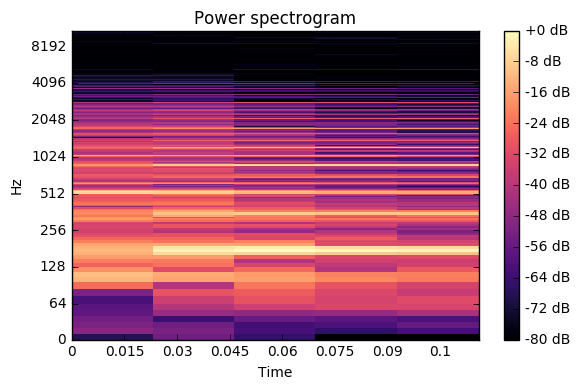

In [24]:
inputs = []
#print(D.shape)
for o in onset_bt:
    #print(D[o:o+3])
    #inputs.append(D[o:o+3])
    #print(o)
    #print(D[:,o:(o+3)])
    inputs.append(D[:,o:(o+5)])

inputs = np.array(inputs)
inputs = np.swapaxes(inputs,1,2)
print(inputs.shape)
librosa.display.specshow(librosa.amplitude_to_db(inputs[0].T,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

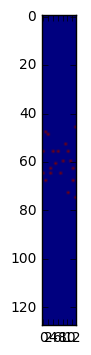

In [38]:
one_hot = np.zeros((128, len(onset_groups)))

for i,onset_time in enumerate(onset_groups):
        #print i
        pitch_set = onset_groups[onset_time]
        for note in pitch_set:
            # note on
            one_hot[note,i] = 1

plt.imshow(one_hot)